## 04.P Geospatial Data Problem Set – Summarizing Airborne Snow Observatory Data

__Background:__ For your graduate research, you are using lidar-derived snow water equivalent (SWE) estimates to assimilate into a physics based hydrology model to make streamflow predictions. In thinking through your hypotheses portions of the landscape where SWE data will have the most impact, you are reminded of a figure you saw in a presentation at a recent meeting. The figure shows how the distribution of SWE and land area across a range of elevation interact to control the distribution of water storage in the landscape. The figure looked like the following:

<img src='../img/aso_swe.png' alt='Upper Colorado ASO Analysis' width='750' style='display: block; margin: 0 auto'/>

You already have grids of estimated SWE from the Airborne Snow Observatory (ASO) for 4 separate dates at a 50 m spatial resolution, and a coregistered digital elevation model of the study area – the East River in the Colorado Rocky Mountains.  

__Task:__ Use the skills you've developed and the example notebooks you've examined in this module to create an image like the above. The ASO and coregistered DEM can be found in [this Google Drive folder](https://drive.google.com/drive/u/0/folders/1SkjOWPPJe5N25arCW6qbf2ZJWQsrUAAp). Use any of the four ASO files, which corresponds to 2 different dates in 2018 or 2019, or write your code generically to plot any or all dates. You should only need `rasterio`, `numpy`, and `matplotlib` to create this figure.    

In [3]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

swe_fname = 'C:/Users/gretchenhough/Documents/ghough-geos505-1/aso_data/ASO_50M_SWE_USCOGE_20180331.tif'
el_fname = 'C:/Users/gretchenhough/Documents/ghough-geos505-1/aso_data/coge_dem_50m.tif'

In [4]:
dem=rio.open(el_fname).read(1)
swe=rio.open(swe_fname).read(1)

dem_meta=rio.open(el_fname).meta
swe_meta=rio.open(swe_fname).meta

print(dem_meta)
print(swe_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 924, 'height': 1033, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32613"]]'), 'transform': Affine(50.000101089, 0.0, 305100.616845078,
       0.0, -50.000101089, 4330208.754711756)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 924, 'height': 1033, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM

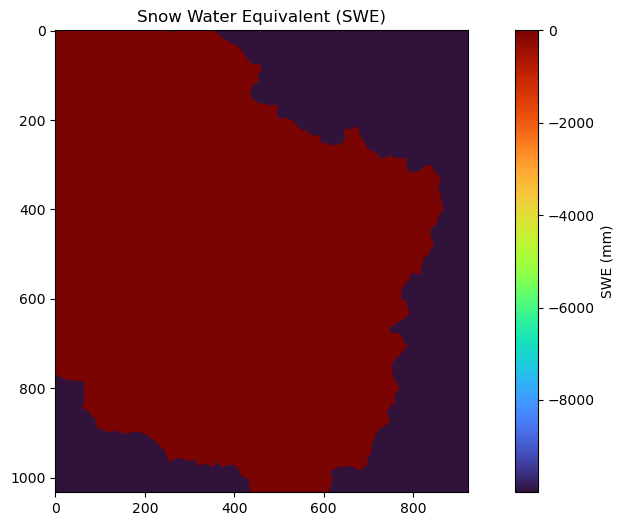

In [5]:
plt.figure(figsize=(12,6))
plt.imshow(swe, cmap='turbo')
plt.colorbar(label='SWE (mm)')
plt.title('Snow Water Equivalent (SWE)')
plt.show()

In [6]:
print(np.nanmin(swe))
print(np.nanmax(swe))
print(np.unique(swe[:1000:100, :1000:100]))

-9999.0
3.1331856
[-9.99900000e+03  0.00000000e+00  4.45811136e-04  1.78778265e-03
  1.04527948e-02  1.16500733e-02  2.96273548e-02  3.23641077e-02
  3.55193987e-02  4.73909192e-02  4.75739464e-02  5.31129651e-02
  7.55042434e-02  1.01748422e-01  1.05782039e-01  1.17818244e-01
  1.56832993e-01  1.57215714e-01  1.70723602e-01  2.26350725e-01
  2.29847535e-01  2.45099425e-01  2.50096411e-01  2.59464860e-01
  2.70407975e-01  2.87782222e-01  2.96616346e-01  2.97680587e-01
  2.98894107e-01  3.15693289e-01  3.22700828e-01  3.24108481e-01
  3.40900123e-01  3.58147949e-01  3.74737233e-01  3.91280711e-01
  4.40908104e-01  4.61477071e-01  4.65465486e-01  5.05257249e-01
  5.44349730e-01  5.47948122e-01  5.71571529e-01  1.03495693e+00]


Ok, so I know from looking at max and min that there are no data values recorded as -9999. The max SWE in CO on March 31 of 3 mm, though? I think my units are in meters. I'm converting to mm.

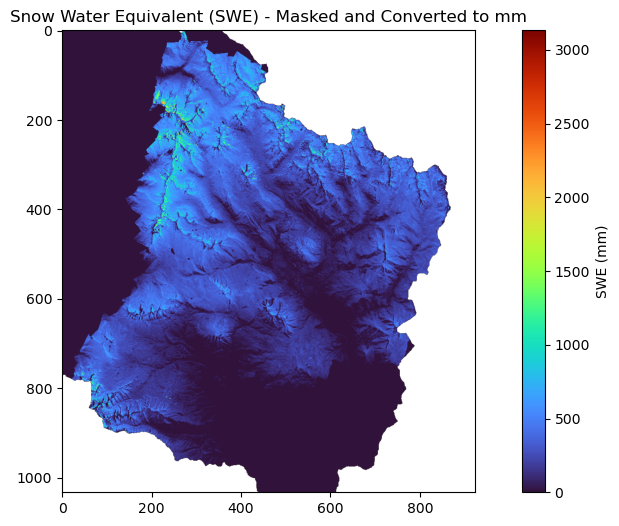

In [7]:
swe_masked = np.where(swe==-9999, np.nan, swe) # replace -9999 with NaN
swe_masked_mm=swe_masked * 1000  # Convert from m to mm

plt.figure(figsize=(12,6))
plt.imshow(swe_masked_mm, cmap='turbo')
plt.colorbar(label='SWE (mm)')
plt.title('Snow Water Equivalent (SWE) - Masked and Converted to mm')
plt.show()

The NW corner of the map is super suspicious still. I'm going to see if those are false zeros.

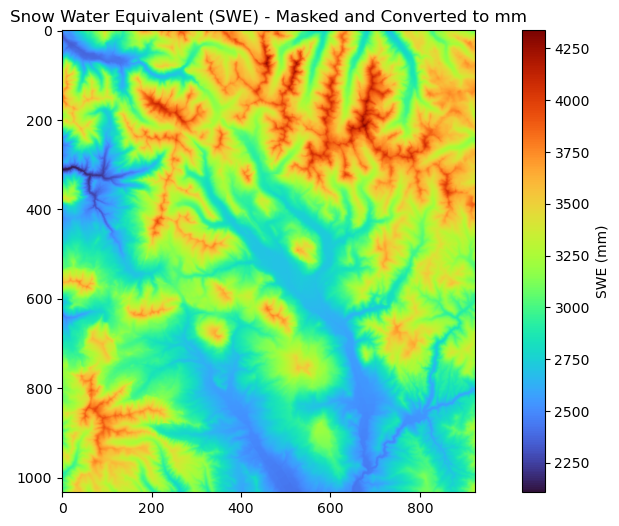

In [8]:
plt.figure(figsize=(12,6))
plt.imshow(dem, cmap='turbo')
plt.colorbar(label='SWE (mm)')
plt.title('Snow Water Equivalent (SWE) - Masked and Converted to mm')
plt.show()

Ok, so the NW corner is definitely a false zero. There are some areas of higher elevation that should definitely have significant SWE, but the whole area just looks like it's truncated to the west of the ridge running N/S. I can't mask with an evelvation cut off. Chat to the rescue...

In [9]:
swe_src=rio.open(swe_fname) #checking in rasterio for nodata value
nodata=swe_src.nodata
print(nodata)

-9999.0


So the null data is recorded as -9999.

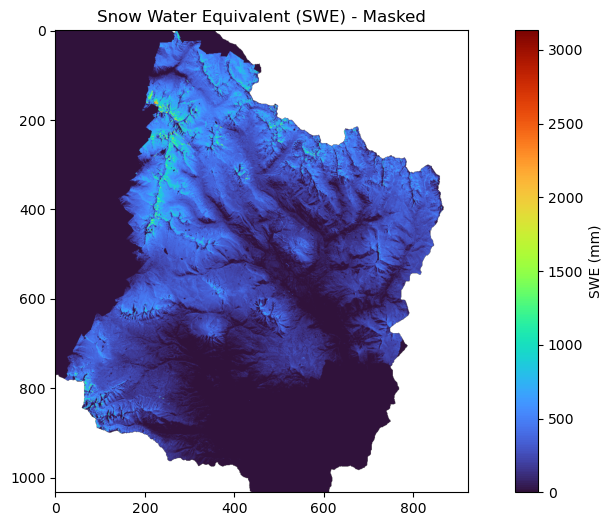

In [52]:
swe_raw=rio.open(swe_fname).read(1)
swe_masked2=np.where(swe_raw==nodata, np.nan, swe_raw) # replace -9999 with NaN
swe_masked2_mm=swe_masked2 * 1000  # Convert from m to mm

plt.figure(figsize=(12,6))
plt.imshow(swe_masked2_mm, cmap='turbo')
plt.colorbar(label='SWE (mm)')
plt.title('Snow Water Equivalent (SWE) - Masked')
plt.show()

Reloading, renaming, and eliminating -9999 didn't clear the artifcat in the NW.

In [11]:
corner=swe_raw[0:50, 0:50]
print(np.unique(corner))
print(np.min(corner))
print(np.max(corner))
print(np.sum(corner==-9999))
print(np.sum(corner==0))

[0.]
0.0
0.0
0
2500


Checking the values in that zone of the map, it's all zeros, no other numbers. Clearly for that portion of the map, zeros got put in for null values where they were recorded as -9999 elsewhere. I'm going to have to wipe zeros out of the array, too.

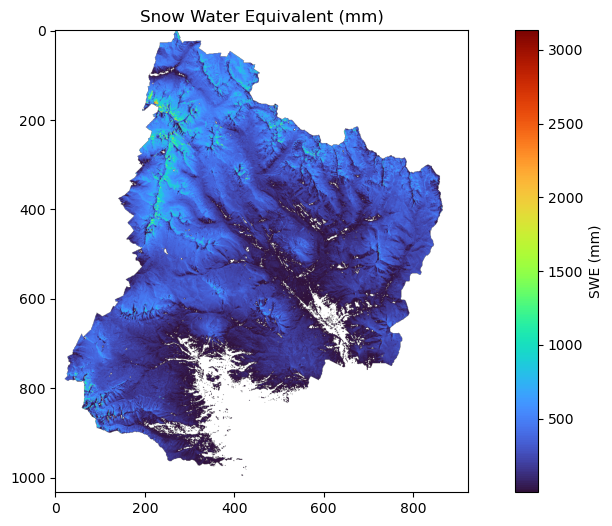

In [12]:
swe_masked3=np.where((swe_raw==nodata) | (swe_raw==0), np.nan, swe_raw) # replace nodata and 0 with NaN
swe_masked3_mm=swe_masked3 * 1000  # Convert from m to mm
plt.figure(figsize=(12,6))
plt.imshow(swe_masked3_mm, cmap='turbo')
plt.colorbar(label='SWE (mm)')
plt.title('Snow Water Equivalent (mm)')
plt.show()

I don't like this because it eliminated some real 0 values, or what I believe are true zeros in the SE part of the map, but I guess they won't contribute to the snow volume and elevation plots we want anyway. I need to mask that NW corner and cannot figure out another way to do it, so I am masking both 0 and -9999 values.

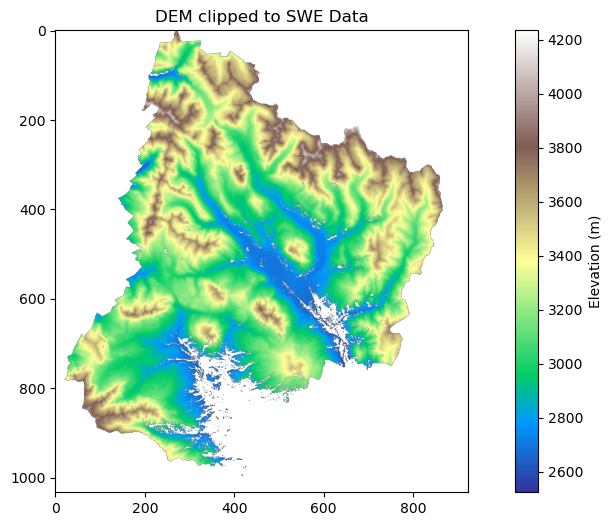

In [13]:
dem_masked = np.where(np.isnan(swe_masked3_mm), np.nan, dem)  # mask DEM where SWE is NaN
plt.figure(figsize=(12,6))
plt.imshow(dem_masked, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title('DEM clipped to SWE Data')
plt.show()

In [25]:
zmin = np.nanmin(dem_masked)
zmax = np.nanmax(dem_masked)
zmean = np.nanmean(dem_masked)

dem_min = np.nanmin(dem)

print(zmin)
print(zmax)
print(zmean)
print(dem_min)

2523.8284
4235.703
3203.4922
2107.9844


In [28]:
bins=np.arange(zmin, zmax+50, 50)
bincount=len(bins)-1
mean_swe = np.full(bincount, np.nan)
median_swe = np.full(bincount, np.nan)
std_swe = np.full(bincount, np.nan)

for i in range(bincount):
    bin_mask = (dem_masked >= bins[i]) & (dem_masked < bins[i+1])
    mean_swe[i] = np.nanmean(swe_masked3_mm[bin_mask])
    median_swe[i] = np.nanmedian(swe_masked3_mm[bin_mask])
    std_swe[i] = np.nanstd(swe_masked3_mm[bin_mask])

print(mean_swe)
print(median_swe)
print(std_swe)

[  3.76172018   6.69864798  13.48111153  37.65792465  56.47222137
  69.89812469  86.89339447 113.92271423 144.67881775 169.91600037
 191.78755188 212.05596924 237.09716797 266.16217041 295.24395752
 321.70703125 348.28414917 373.78485107 402.63659668 427.68707275
 452.42407227 459.22024536 448.96505737 440.44125366 441.40820312
 460.66271973 454.11578369 443.21826172 433.49853516 469.42181396
 472.06814575 507.84915161 315.41958618 360.37814331 228.27859497]
[  1.26667953   1.13836277   3.31815886  26.77545166  41.25931549
  49.36022568  68.1317749  100.37554932 135.29167175 163.28352356
 188.05331421 207.17959595 232.90563965 259.09442139 285.99603271
 308.29238892 332.74859619 352.74264526 376.21356201 401.11206055
 430.20065308 438.76361084 422.30541992 407.05285645 399.29586792
 412.95291138 407.81619263 380.45477295 364.81686401 404.59841919
 424.58755493 509.40328979 317.35427856 331.47763062 228.27859497]
[  6.32601166  16.63331604  31.84091377  39.82881927  56.20627975
  69.588

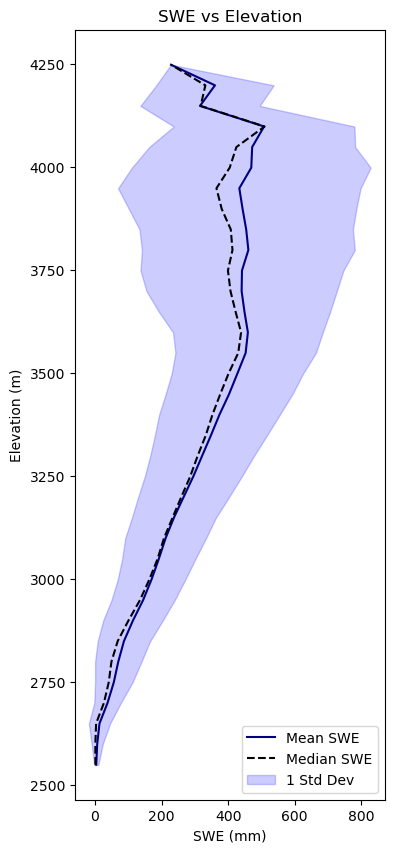

In [42]:
bin_centers = (bins[:-1] + bins[1:]) / 2

fig1, ax1 = plt.subplots(figsize=(4,10))
ax1.plot(mean_swe, bin_centers, label='Mean SWE', color='navy')
ax1.plot(median_swe, bin_centers, label='Median SWE', color='black', linestyle='--')
ax1.fill_betweenx(bin_centers, mean_swe - std_swe, mean_swe + std_swe, color='blue', alpha=0.2, label='1 Std Dev')
ax1.set_ylabel('Elevation (m)')
ax1.set_xlabel('SWE (mm)')
ax1.set_title('SWE vs Elevation')
ax1.legend()

plt.show()



SWE looks good. I'm upset that I can't keep the SE zeros, but... I battled for a while and have deleted all of those failed efforts. I'm going to work on the area binning now.

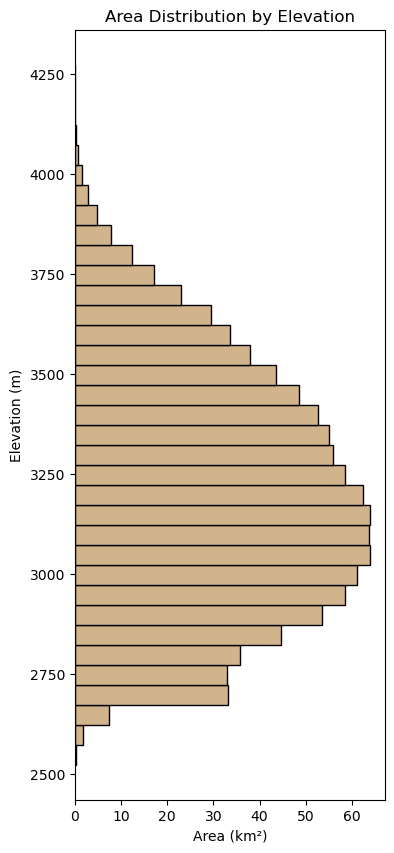

In [43]:
area_pixel= 2500  # 50m x 50m in m²

binned_area = np.full(bincount, np.nan)

for i in range(bincount):
    bin_mask = (dem_masked >= bins[i]) & (dem_masked < bins[i+1])
    pixel_count = np.nansum(bin_mask)
    binned_area[i] = pixel_count * area_pixel/1000/1000  # in km²


fig2, ax2 = plt.subplots(figsize=(4, 10))
ax2.barh(bin_centers, binned_area, height=50, color='tan', edgecolor='black')
ax2.set_xlabel('Area (km²)')
ax2.set_ylabel('Elevation (m)')
ax2.set_title('Area Distribution by Elevation')

plt.show()


Ok now I need SWE volume by elevation bin.

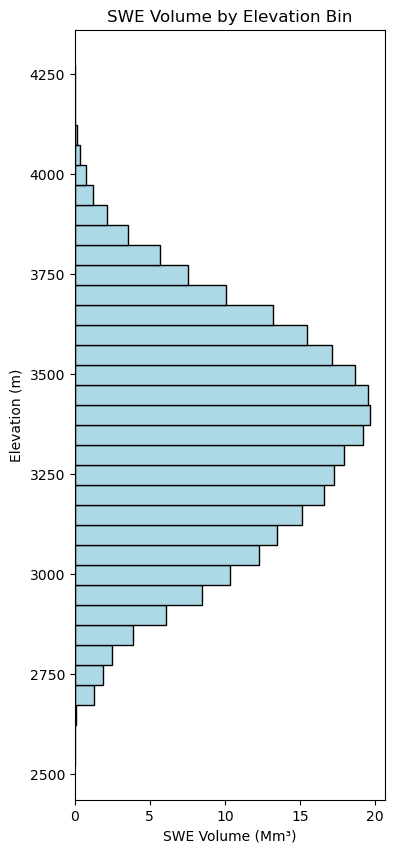

In [ ]:
swe_volume = mean_swe/1000 * binned_area # in millions of m³, remember binned_area is in km², so to get it to m³, need to multiply by 1,000,000. But then I want Mm³, so I take my m^3 divided by 1,000,000. The millions cancel.

fig3, ax3 = plt.subplots(figsize=(4, 10))
ax3.barh(bin_centers, swe_volume, height=50, color='lightblue', edgecolor='black')
ax3.set_xlabel('SWE Volume (Mm³)')
ax3.set_ylabel('Elevation (m)')
ax3.set_title('SWE Volume by Elevation')
plt.show()

Ok, putting them all together...

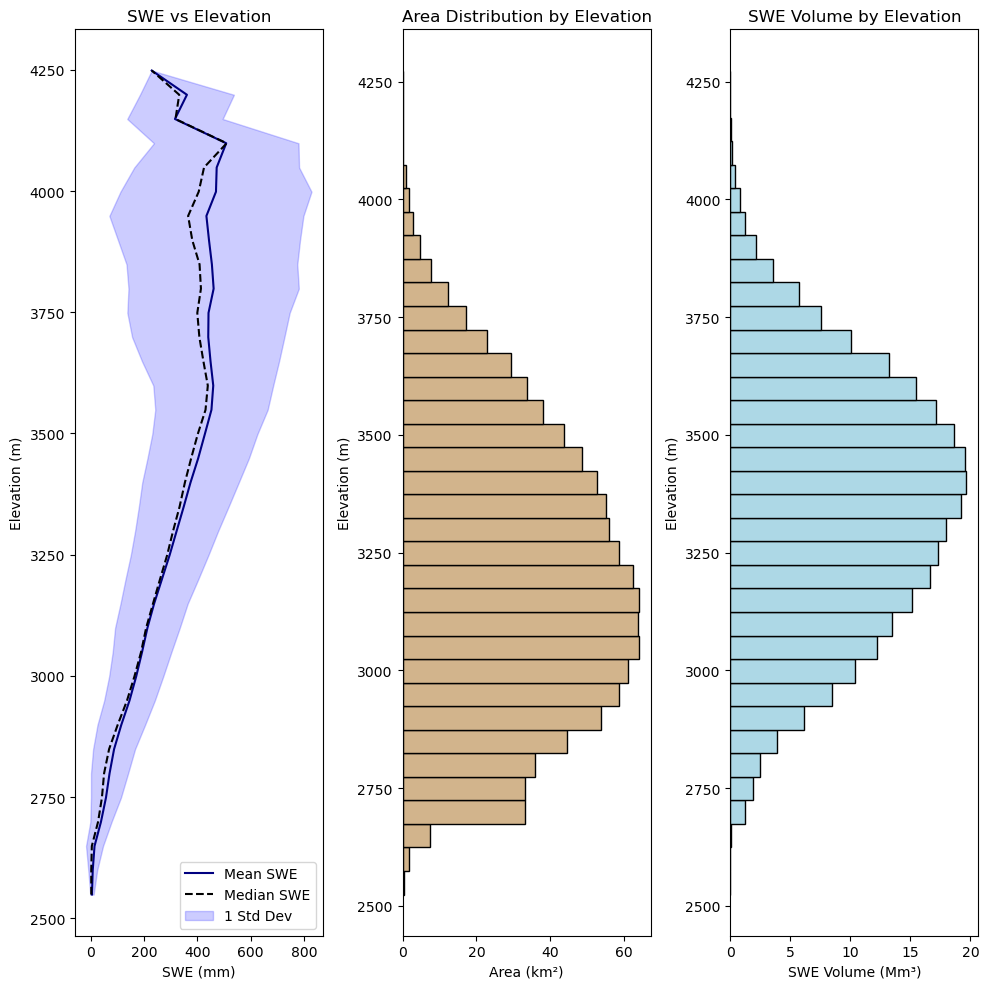

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.plot(mean_swe, bin_centers, label='Mean SWE', color='navy')
ax1.plot(median_swe, bin_centers, label='Median SWE', color='black', linestyle='--')
ax1.fill_betweenx(bin_centers, mean_swe - std_swe, mean_swe + std_swe, color='blue', alpha=0.2, label='1 Std Dev')
ax1.set_ylabel('Elevation (m)')
ax1.set_xlabel('SWE (mm)')
ax1.set_title('SWE vs Elevation')
ax1.legend()
ax2.barh(bin_centers, binned_area, height=50, color='tan', edgecolor='black')
ax2.set_xlabel('Area (km²)')
ax2.set_ylabel('Elevation (m)')
ax2.set_title('Area Distribution by Elevation')
ax3.barh(bin_centers, swe_volume, height=50, color='lightblue', edgecolor='black')
ax3.set_xlabel('SWE Volume (Mm³)')
ax3.set_ylabel('Elevation (m)')
ax3.set_title('SWE Volume by Elevation')
plt.tight_layout()
plt.show()

Ok, that's the final plot with no zeros. But I don't like it. So I'm going to do it again with my original SWE_masked where I only cut off -9999 values.

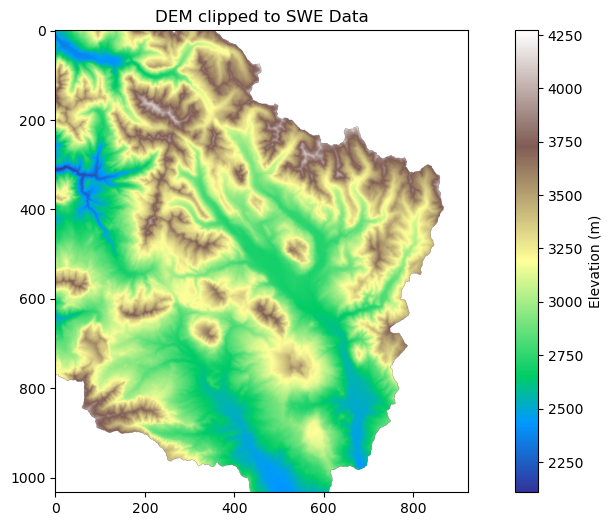

In [53]:
dem_mask2 = np.where(np.isnan(swe_masked), np.nan, dem)  # mask DEM where SWE is NaN
plt.figure(figsize=(12,6))
plt.imshow(dem_mask2, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title('DEM clipped to SWE Data')
plt.show()

In [61]:
zmin2= np.nanmin(dem_mask2)
zmax2= np.nanmax(dem_mask2)

bins2=np.arange(zmin2, zmax2+50, 50)
bincount2=len(bins2)-1

bin_centers2 = (bins2[:-1] + bins2[1:]) / 2

mean_swe2 = np.full(bincount2, np.nan)
median_swe2 = np.full(bincount2, np.nan)
std_swe2 = np.full(bincount2, np.nan)

for i in range(bincount2):
    bin_mask2 = (dem_mask2 >= bins2[i]) & (dem_mask2 < bins2[i+1])
    mean_swe2[i] = np.nanmean(swe_masked_mm[bin_mask2])
    median_swe2[i] = np.nanmedian(swe_masked_mm[bin_mask2])
    std_swe2[i] = np.nanstd(swe_masked_mm[bin_mask2])

area2 = np.full(bincount2, np.nan)

for i in range(bincount2):
    bin_mask2 = (dem_mask2 >= bins2[i]) & (dem_mask2 < bins2[i+1])
    pixel_count2 = np.nansum(bin_mask2)
    area2[i] = pixel_count2 * area_pixel/1000/1000  # in km²



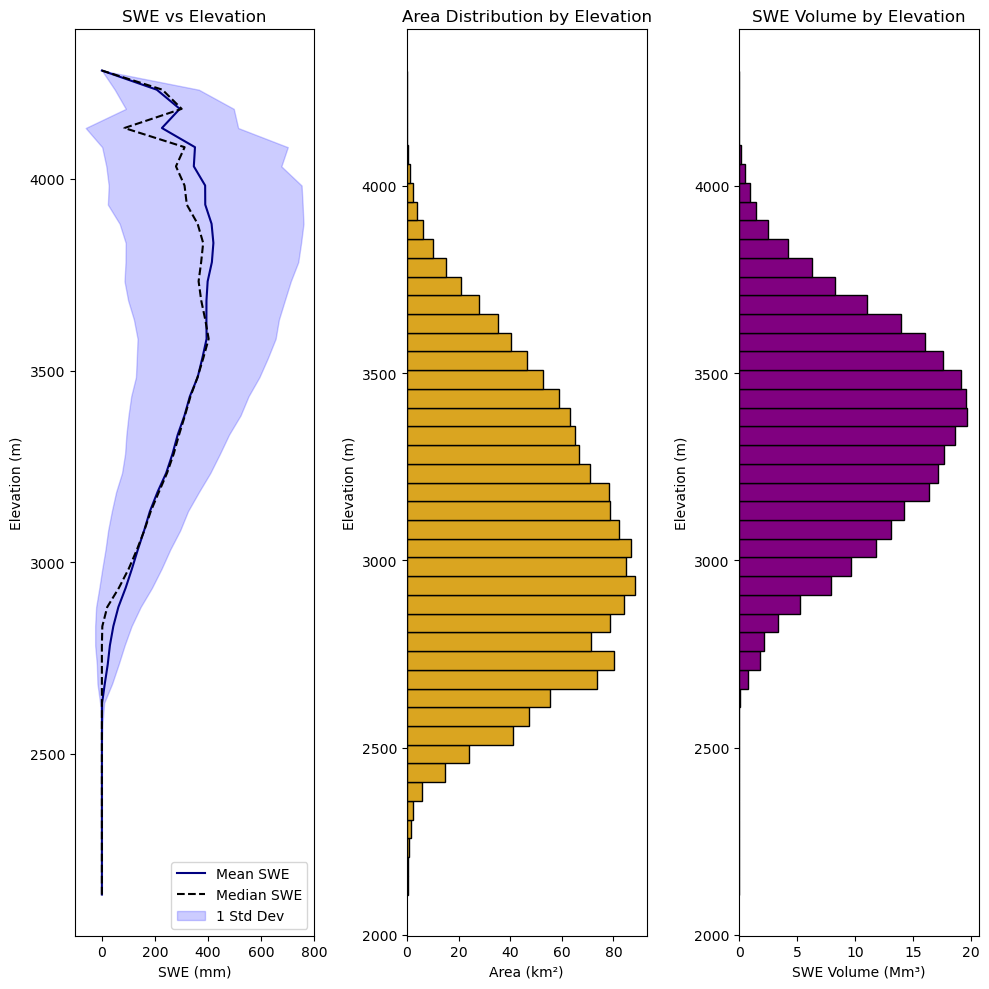

In [62]:
SWE_vol2 = mean_swe2/1000 * area2 # in millions of m³

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.plot(mean_swe2, bin_centers2, label='Mean SWE', color='navy')
ax1.plot(median_swe2, bin_centers2, label='Median SWE', color='black', linestyle='--')
ax1.fill_betweenx(bin_centers2, mean_swe2 - std_swe2, mean_swe2 + std_swe2, color='blue', alpha=0.2, label='1 Std Dev')
ax1.set_ylabel('Elevation (m)')
ax1.set_xlabel('SWE (mm)')
ax1.set_title('SWE vs Elevation')
ax1.legend()
ax2.barh(bin_centers2, area2, height=50, color='goldenrod', edgecolor='black')
ax2.set_xlabel('Area (km²)')
ax2.set_ylabel('Elevation (m)')
ax2.set_title('Area Distribution by Elevation')
ax3.barh(bin_centers2, SWE_vol2, height=50, color='purple', edgecolor='black')
ax3.set_xlabel('SWE Volume (Mm³)')
ax3.set_ylabel('Elevation (m)')
ax3.set_title('SWE Volume by Elevation')
plt.tight_layout()
plt.show()


Side by side plots comparing both methods.

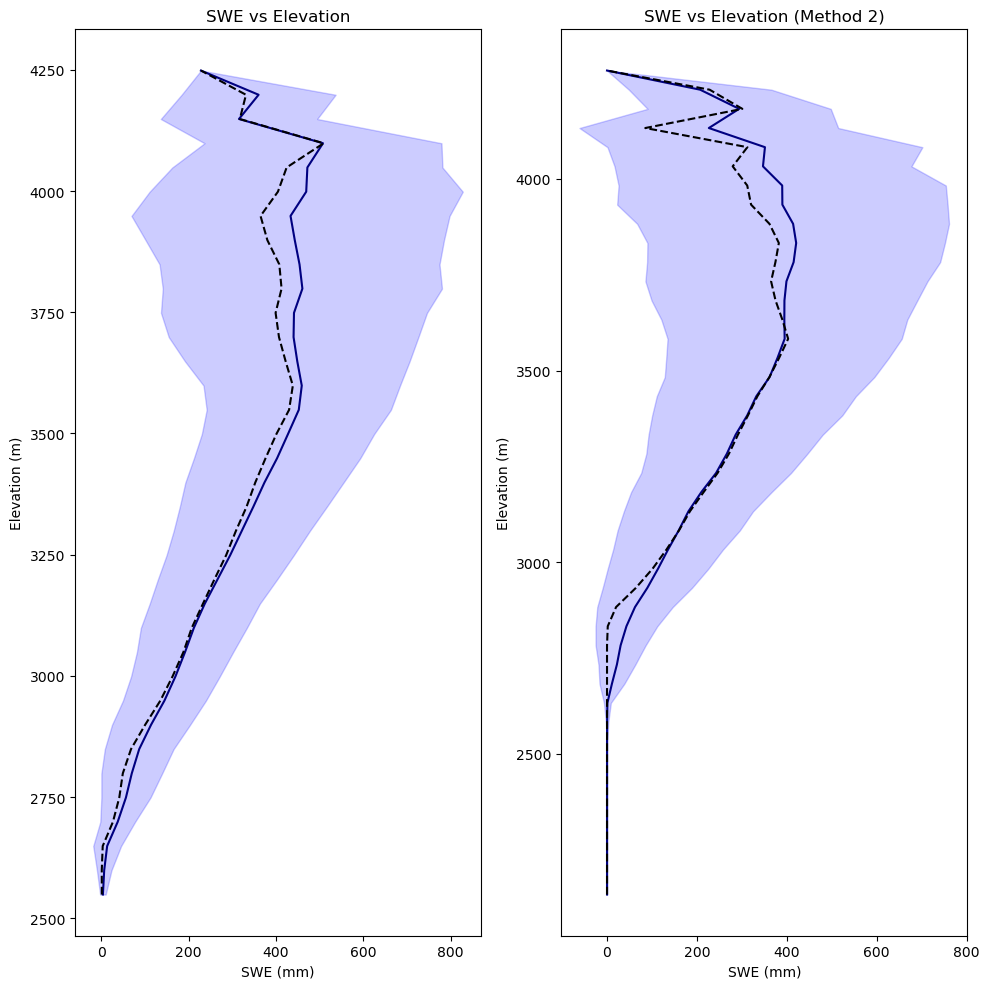

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.plot(mean_swe, bin_centers, label='Mean SWE', color='navy')
ax1.plot(median_swe, bin_centers, label='Median SWE', color='black', linestyle='--')
ax1.fill_betweenx(bin_centers, mean_swe - std_swe, mean_swe + std_swe, color='blue', alpha=0.2, label='1 Std Dev')
ax1.set_ylabel('Elevation (m)')
ax1.set_xlabel('SWE (mm)')
ax1.set_title('SWE vs Elevation')
ax2.plot(mean_swe2, bin_centers2, label='Mean SWE', color='navy')
ax2.plot(median_swe2, bin_centers2, label='Median SWE', color='black', linestyle='--')
ax2.fill_betweenx(bin_centers2, mean_swe2 - std_swe2, mean_swe2 + std_swe2, color='blue', alpha=0.2, label='1 Std Dev')
ax2.set_ylabel('Elevation (m)')
ax2.set_xlabel('SWE (mm)')
ax2.set_title('SWE vs Elevation (Method 2)')
plt.tight_layout()
plt.show()

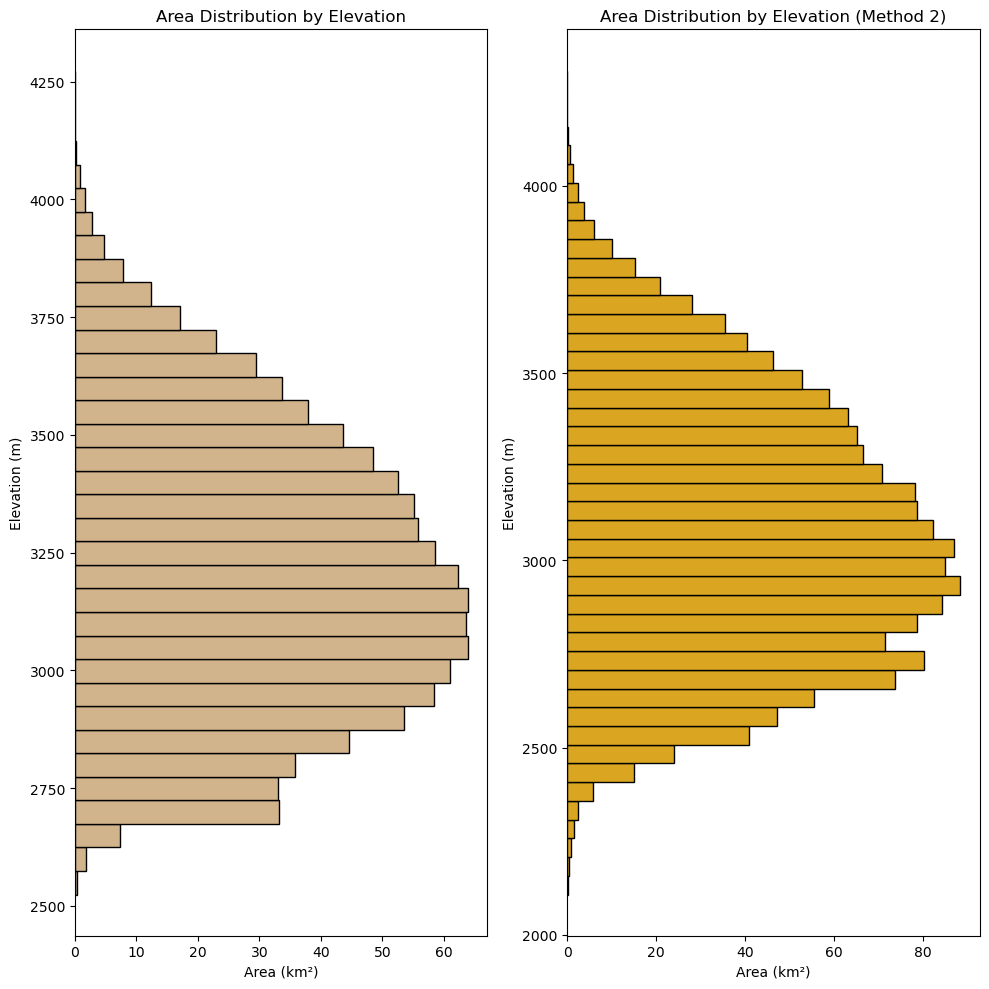

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.barh(bin_centers, binned_area, height=50, color='tan', edgecolor='black')
ax1.set_xlabel('Area (km²)')
ax1.set_ylabel('Elevation (m)')
ax1.set_title('Area Distribution by Elevation')
ax2.barh(bin_centers2, area2, height=50, color='goldenrod', edgecolor='black')
ax2.set_xlabel('Area (km²)')
ax2.set_ylabel('Elevation (m)')
ax2.set_title('Area Distribution by Elevation (Method 2)')
plt.tight_layout()
plt.show()

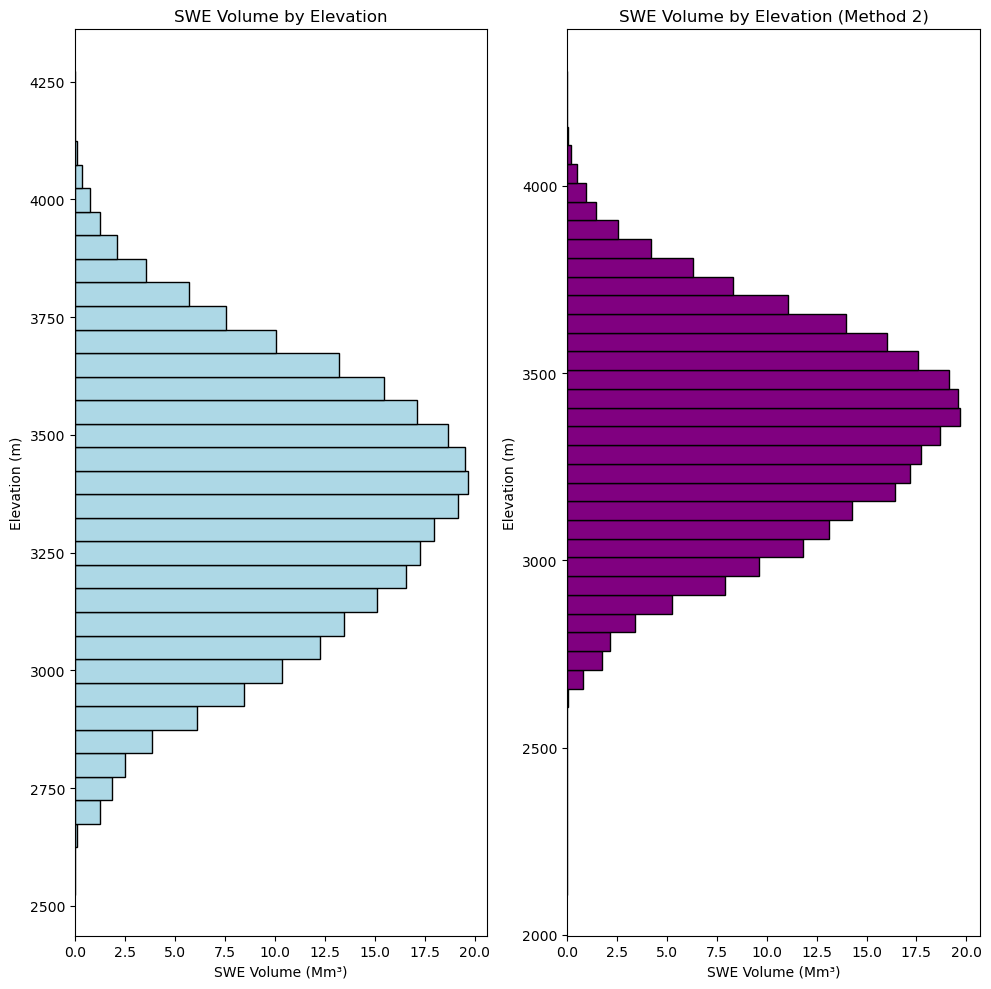

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.barh(bin_centers, swe_volume, height=50, color='lightblue', edgecolor='black')
ax1.set_xlabel('SWE Volume (Mm³)')
ax1.set_ylabel('Elevation (m)')
ax1.set_title('SWE Volume by Elevation')
ax2.barh(bin_centers2, SWE_vol2, height=50, color='purple', edgecolor='black')
ax2.set_xlabel('SWE Volume (Mm³)')
ax2.set_ylabel('Elevation (m)')
ax2.set_title('SWE Volume by Elevation (Method 2)')
plt.tight_layout()
plt.show()

I can't look at SWE volume and tell you quantitatively if there is a difference from the two methods (there shouldn't be), but what I can see comparing side to side is that the majority of true zeros I cut off were at lower elevations (logical!). Cutting off the real zeros with the false zeros did significantly reduce the area graph in the first method, especially for lower elevation bins. The SWE graph wasn't actually heavily impacted by leaving in false zeros. The SWE graphs still follow roughly the same shape. The false zeros from the NW corner drag down the mean and median values for higher elevations.  We know the true SWE curve lies somewhere between these two methods, because removing real zeros will give a higher mean and median than is actually true.